### Requirements

In [78]:
from dataset import*
from utility import*
from training import*
from baseline import*
from transformer import*

# Head pose DL model from https://github.com/thohemp/6drepnet
from sixdrepnet import SixDRepNet
import dlib

from torch.optim import lr_scheduler 
# Import models
from torchvision import models
from vit_pytorch.twins_svt import TwinsSVT # MEMORIA NON SUFFICIENTE RIPROVARLO
#from vit_pytorch.vit import ViT
from vit_pytorch.ats_vit import ViT
from vit_pytorch import SimpleViT
from vit_pytorch.crossformer import CrossFormer # MEMORIA NON SUFFICIENTE RIPROVARLO
from vit_pytorch.cross_vit import CrossViT

In [79]:
root_project = '/home/anto/University/Driving-Visual-Attention/'

In [80]:
print(f"We have {'' if torch.cuda.is_available() else 'not'} access to a GPU")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print(torch.cuda.current_device())
    print(torch.cuda.device(0))
    print(torch.cuda.device_count())
    print(torch.cuda.get_device_name(0))
print(device)

We have  access to a GPU
0
1
NVIDIA GeForce RTX 3060 Laptop GPU
cuda


In [81]:
seed_everything(42)

##### Initialize pre-trained models for feature extraction

In [82]:
# Initialize face detector and facial landmarks predictor
predictor = dlib.shape_predictor("/home/anto/University/Driving-Visual-Attention/data/shape_predictor_68_face_landmarks.dat")
headpose_extractor = SixDRepNet()
face_detector = dlib.get_frontal_face_detector()

### Data Loader and Visualization

##### Files where to write the paths and labels

In [83]:
percentage = 100
save_train_file = root_project + 'save/save_train' + str(percentage)
save_val_file = root_project + 'save/save_val' + str(percentage)
save_test_file = root_project + 'save/save_test' + str(percentage)

##### Train Loader

In [84]:
train_dataset_classloader = DataLoaderVisualizer(root_project, save_train_file, percentage, predictor, face_detector, headpose_extractor, 'train')

Building path structure
The dataset has already been prepared, ready to use


##### Validtion Loader

In [85]:
val_dataset_classloader = DataLoaderVisualizer(root_project,save_val_file,percentage,predictor, face_detector, headpose_extractor,'val')

Building path structure
The dataset has already been prepared, ready to use


##### Test Loader

In [86]:
test_dataset_classloader = DataLoaderVisualizer(root_project,save_test_file,percentage,predictor, face_detector, headpose_extractor,'test')

Building path structure
The dataset has already been prepared, ready to use


##### Visualization

In [87]:
#train_dataset_classloader.visualize_dataset()

In [88]:
#val_dataset_classloader.visualize_dataset()

In [89]:
#test_dataset_classloader.visualize_dataset()

### Pytorch Dataset 

In [90]:
# Choose size of the eyes
dim = (32,64)
# mean and std of images, calculated in advance
mean = (0.4570, 0.4422, 0.3900)
std = (0.2376, 0.2295, 0.2261)

my_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(dim, antialias=True),
    transforms.Normalize(mean=mean, std=mean, inplace=True)
])

In [91]:
train_dataset = DGAZEDataset('train','save/save_train'+str(percentage), my_transforms)
print(f'Train dataset len is {len(train_dataset)}')

Train dataset len is 187458


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The bbox is: tensor([1397.,  506., 2550., 1010.])


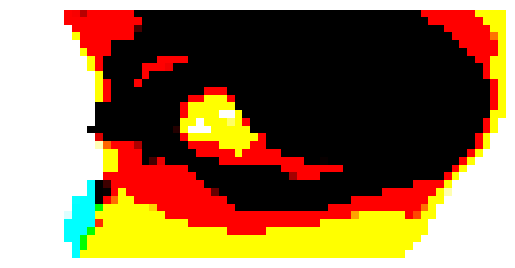

In [92]:
# Print an example of the dataset for correct visualization
img_np = train_dataset[30][0].permute(1, 2, 0).numpy()*255
print(f"The bbox is: {train_dataset[30][3]}")
plt.imshow(img_np)
plt.axis('off')
plt.show()

In [93]:
val_dataset = DGAZEDataset('val','save/save_val'+str(percentage),my_transforms)
print(f'Val dataset len is {len(val_dataset)}')

Val dataset len is 23317


In [94]:
test_dataset = DGAZEDataset('test','save/save_test'+str(percentage),my_transforms)
print(f'Test dataset len is {len(test_dataset)}')

Test dataset len is 22783


In [95]:
# Unite datasets, increse samples in the training or validation
#from torch.utils.data import ConcatDataset
#val_dataset = ConcatDataset([val_dataset,test_dataset])
#train_dataset = ConcatDataset([train_dataset,test_dataset])

### Vision Transformer Model

##### Hyerparameters

In [96]:
EPOCHS = 5
BATCH_SIZE = 16
THRESHOLD = 250
LR = 0.001
BETAS = (0.9, 0.97)
WEIGHT_DECAY = 1e-5
STEP_SIZE = 15000
GAMMA = 0.1
pre_trained = False

In [97]:
model = GazeCNN()
#model = CNNTrans()
model.to(device)

GazeCNN(
  (eye_feature_extractor): EyeFeatureExtractor(
    (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): LeakyReLU(negative_slope=0.01)
    (block): ConvolutionBlock(
      (conv_block): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batch_norm_block): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu_block): LeakyReLU(negative_slope=0.01)
    )
    (pool): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (dropout): Dropout(p=0.1, inplace=False)
    (conv2): Conv2d(8, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (mlp_head): MLPHead(
    (fc_additional): Sequential(
      (0): Linear(in_features=7, out_features=16, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
    )
    (fc_merged): Sequential(
      (0): Linear(in_features=352, out_features=64, bias=True)
      (1): LeakyReLU(negative_

##### Criterion and Optimizer

In [98]:
bbox_accuracy_class = BBoxAccuracy()
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR, betas=BETAS, weight_decay= WEIGHT_DECAY)
scheduler = lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

##### Dataloader

In [99]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

### Training 

In [100]:
if pre_trained:
    ckpt_path = ''
    checkpoint = torch.load(ckpt_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [101]:
wandb.login()
wandb.init(project="Best Baseline CNN", name=f"threshold={THRESHOLD}, batch_size={BATCH_SIZE}, normalization,{percentage}=percent, weight_decay={WEIGHT_DECAY}, lr={LR},betas={BETAS}, gamma={GAMMA}, step_size={STEP_SIZE}")

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


In [102]:
if pre_trained:
    start_epoch = checkpoint['epoch']
    EPOCHS = start_epoch + EPOCHS
else:
    start_epoch = 0
    EPOCHS = EPOCHS

for epoch in range(start_epoch, EPOCHS):
    # Training
    train_loss = train_epoch(model, train_loader, criterion, scheduler, optimizer, device, epoch)
    wandb.log({"epoch": epoch + 1,"train_loss": train_loss})

    # Validation
    val_loss, val_accuracy, bbox_accuracy, paper_accuracy = validate(model, bbox_accuracy_class , val_loader, THRESHOLD, criterion, device, epoch, BATCH_SIZE)
    wandb.log({"epoch": epoch + 1,"val_loss": val_loss})
    wandb.log({"epoch": epoch + 1,"accuracy_threshold": val_accuracy*100})
    wandb.log({"epoch": epoch + 1,"accuracy_bbox": bbox_accuracy*100})
    wandb.log({"epoch": epoch + 1,"accuracy_paper(error)": paper_accuracy})

    #log_image(val_loader, model, device)

# Finish the WandB run
wandb.finish()

Validation Epoch 4: 100%|██████████| 1458/1458 [00:12<00:00, 116.67batch/s, batch accuracy=25.00%] 
wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy_bbox,▁████
accuracy_paper(error),█▂▁▁▁
accuracy_threshold,▁▇███
epoch,▁▁▁▁▁▃▃▃▃▃▅▅▅▅▅▆▆▆▆▆█████
train_loss,█▂▁▁▁
val_loss,█▂▁▁▁
accuracy_bbox,23.96262
accuracy_paper(error),281.18744
accuracy_threshold,54.39386
epoch,5
train_loss,176.45266


In [103]:
save_dict = {
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}
torch.save(save_dict, root_project + 'save/best_CNN_baseline'+'.pth')